# This is a Data Feature Engineering Notebook

### Import libraries for your feature engineering

In [2]:
import warnings
warnings.filterwarnings('ignore')
from subprocess import check_output

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

import seaborn as sns
from numpy import median
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Read the dataset

In [1]:
from platform_sdk.dataset_reader import DatasetReader
from datetime import date
dataset_reader = DatasetReader(PLATFORM_SDK_CLIENT_CONTEXT, dataset_id="5dd2ee272a371e18a8fa7ebd")
df0 = dataset_reader.limit(200000).read()
df0.head()

,_experienceplatform.acctnumber,_experienceplatform.prodcategory,_experienceplatform.qty,_experienceplatform.salesamount,_experienceplatform.pricemethod,timestamp
0,C1030752,Baby Food,1,10,Discount,2018-09-13T00:00:00
1,C1030752,Baby Food,1,16,Discount,2018-09-13T00:00:00
2,C1030752,Cheese,2,11,Discount,2018-09-13T00:00:00
3,C1030752,Baby Food,1,9,Discount,2018-09-13T00:00:00
4,C1030752,Baby Food,1,14,Discount,2018-09-13T00:00:00


### Split the time period into before Aug and After Aug'19 to do analysis on drop in orders and revenue

In [4]:
df0['timestamp'] = df0['timestamp'].astype('datetime64[ns]')
df0['Invoice_Month'] = df0['timestamp'].dt.month
df0.loc[(df0['Invoice_Month'] <= 8) ,'Timeperiod'] = '1'
df0.loc[(df0['Invoice_Month'] > 8) ,'Timeperiod'] = '2'

### Create metrics - store orders, returns, revenue and quantity bought for Timeperiod 1 and Timeperiod 2

### The data is split into orders and returns to calculate returns separately

In [5]:
df_orders = df0[df0['_experienceplatform.qty']>0]
df_returns= df0[df0['_experienceplatform.qty']<0]
df00 = df_orders

df_GroupByUser=df00.groupby(['_experienceplatform.acctnumber'])['timestamp'].count().to_frame('Store_Orders_Placed').reset_index()
df1=df00.groupby(['_experienceplatform.acctnumber'])['timestamp'].apply(min).to_frame('First_Order_Date').reset_index()
df2=df00.groupby(['_experienceplatform.acctnumber'])['timestamp'].apply(max).to_frame('Last_Order_Date').reset_index()
df3=df00.groupby(['_experienceplatform.acctnumber'])['_experienceplatform.salesamount'].sum().to_frame('Store_Revenue').reset_index()
df4=df00.groupby(['_experienceplatform.acctnumber'])['_experienceplatform.qty'].sum().to_frame('Store_Product_Quantity').reset_index()

df_GroupByUser['First_Order_Date'] = df1['First_Order_Date']
df_GroupByUser['Last_Order_Date'] = df2['Last_Order_Date']
df_GroupByUser['Store_Revenue'] = df3['Store_Revenue']
df_GroupByUser['Store_Product_Quantity'] = df4['Store_Product_Quantity']

# Calculate total revenue and orders for each timeperiod for modeling
Store_Orders_Placed = pd.pivot_table(df00, index='_experienceplatform.acctnumber', columns=['Timeperiod'],
               values='timestamp', aggfunc='count', fill_value=0).reset_index()

Store_Revenue = pd.pivot_table(df00, index='_experienceplatform.acctnumber', columns=['Timeperiod'],
               values='_experienceplatform.salesamount', aggfunc='sum', fill_value=0).reset_index()

Store_Product_Quantity = pd.pivot_table(df00, index='_experienceplatform.acctnumber', columns=['Timeperiod'],
               values='_experienceplatform.qty', aggfunc='sum', fill_value=0).reset_index()


df_GroupByUser['Store_Orders_Placed_TP1'] = Store_Orders_Placed['1']
df_GroupByUser['Store_Orders_Placed_TP2'] = Store_Orders_Placed['2']

df_GroupByUser['Store_Revenue_TP1'] = Store_Revenue['1']
df_GroupByUser['Store_Revenue_TP2'] = Store_Revenue['2']

df_GroupByUser['Store_Product_Quantity_TP1'] = Store_Product_Quantity['1']
df_GroupByUser['Store_Product_Quantity_TP2'] = Store_Product_Quantity['2']


In [6]:
df01 = df_returns

dfr_GroupByUser=df01.groupby(['_experienceplatform.acctnumber'])['timestamp'].count().to_frame('Store_Orders_Returned').reset_index()
df8=df01.groupby(['_experienceplatform.acctnumber'])['timestamp'].apply(min).to_frame('First_Return_Date').reset_index()
df9=df01.groupby(['_experienceplatform.acctnumber'])['timestamp'].apply(max).to_frame('Last_Return_Date').reset_index()
df10=df01.groupby(['_experienceplatform.acctnumber'])['_experienceplatform.salesamount'].sum().to_frame('Store_Revenue_Refund').reset_index()
df11=df01.groupby(['_experienceplatform.acctnumber'])['_experienceplatform.qty'].sum().to_frame('Store_Product_Quantity_Returned').reset_index()

# Calculate total revenue and orders for each timeperiod for modeling
Store_Orders_Returned = pd.pivot_table(df01, index='_experienceplatform.acctnumber', columns=['Timeperiod'],
               values='timestamp', aggfunc='count', fill_value=0).reset_index()

Store_Revenue_Refund = pd.pivot_table(df01, index='_experienceplatform.acctnumber', columns=['Timeperiod'],
               values='_experienceplatform.salesamount', aggfunc='sum', fill_value=0).reset_index()

Store_Product_Quantity_Returned = pd.pivot_table(df01, index='_experienceplatform.acctnumber', columns=['Timeperiod'],
               values='_experienceplatform.qty', aggfunc='sum', fill_value=0).reset_index()

dfr_GroupByUser['Store_Orders_Returned'] = abs(dfr_GroupByUser['Store_Orders_Returned'])

dfr_GroupByUser['First_Return_Date'] = df8['First_Return_Date']
dfr_GroupByUser['Last_Return_Date'] = df9['Last_Return_Date']
dfr_GroupByUser['Store_Revenue_Refund'] = abs(df10['Store_Revenue_Refund'])
dfr_GroupByUser['Store_Product_Quantity_Returned'] = abs(df11['Store_Product_Quantity_Returned'])

dfr_GroupByUser['Store_Orders_Returned_TP1'] = abs(Store_Orders_Returned['1'])
dfr_GroupByUser['Store_Orders_Returned_TP2'] = abs(Store_Orders_Returned['2'])

dfr_GroupByUser['Store_Revenue_Refund_TP1'] = abs(Store_Revenue_Refund['1'])
dfr_GroupByUser['Store_Revenue_Refund_TP2'] = abs(Store_Revenue_Refund['2'])

dfr_GroupByUser['Store_Product_Quantity_Returned_TP1'] = abs(Store_Product_Quantity_Returned['1'])
dfr_GroupByUser['Store_Product_Quantity_Returned_TP2'] = abs(Store_Product_Quantity_Returned['2'])


In [35]:
dfr_GroupByUser.columns

Index(['_experienceplatform.acctnumber', 'Store_Orders_Returned',
       'First_Return_Date', 'Last_Return_Date', 'Store_Revenue_Refund',
       'Store_Product_Quantity_Returned', 'Store_Orders_Returned_TP1',
       'Store_Orders_Returned_TP2', 'Store_Revenue_Refund_TP1',
       'Store_Revenue_Refund_TP2', 'Store_Product_Quantity_Returned_TP1',
       'Store_Product_Quantity_Returned_TP2'],
      dtype='object')

### Merge orders and returns data - Note that this is now aggregated at a customer level i.e., 1 customer will have one record

In [7]:
df_store = pd.merge(df_GroupByUser, dfr_GroupByUser, how='outer',on = '_experienceplatform.acctnumber')
df_store= df_store.reset_index(drop=True)

df_store['Store_Orders_Returned'] = df_store['Store_Orders_Returned'].fillna(0)
df_store['Store_Orders_Returned_TP1'] = df_store['Store_Orders_Returned_TP1'].fillna(0)
df_store['Store_Orders_Returned_TP2'] = df_store['Store_Orders_Returned_TP2'].fillna(0)

df_store['Store_Revenue_Refund'] = df_store['Store_Revenue_Refund'].fillna(0)
df_store['Store_Revenue_Refund_TP1'] = df_store['Store_Revenue_Refund_TP1'].fillna(0)
df_store['Store_Revenue_Refund_TP2'] = df_store['Store_Revenue_Refund_TP2'].fillna(0)

df_store['Store_Product_Quantity_Returned'] = df_store['Store_Product_Quantity_Returned'].fillna(0)
df_store['Store_Product_Quantity_Returned_TP1'] = df_store['Store_Product_Quantity_Returned_TP1'].fillna(0)
df_store['Store_Product_Quantity_Returned_TP2'] = df_store['Store_Product_Quantity_Returned_TP2'].fillna(0)


In [8]:
df_store['First_Order_Date'] = pd.to_datetime(df_store['First_Order_Date'], errors='coerce')
df_store['Last_Order_Date'] = pd.to_datetime(df_store['Last_Order_Date'], errors='coerce')

## Defining Churn 
Churn is defined as customers who have made a purchase on or before August but not made any purchase after Aug. 

In [9]:
df_store = df_store[~(df_store.First_Order_Date.isnull())]

df_store = df_store[df_store['First_Order_Date']<= '2019-08-31']
df_store['Churn']=1
df_store.loc[(df_store['First_Order_Date']<= '2019-08-31') & (df_store['Last_Order_Date']> '2019-08-31'), 'Churn'] = 0

### View the distribution of Churn

In [42]:
df_store['Churn'].value_counts()

0    368
1    335
Name: Churn, dtype: int64

Non Churners : 368
Churners : 335
Total Customers : 703
Proportion : 47 %


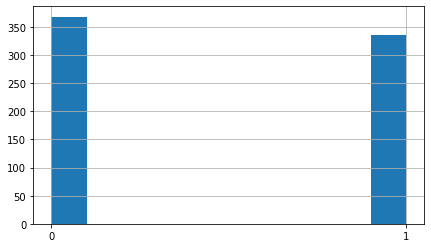

In [44]:
df = df_store

plt.figure(figsize=(7,4))

print ( 'Non Churners : ' + str(df_store[df_store['Churn']==0]['_experienceplatform.acctnumber'].count()))
print ('Churners : ' + str(df_store[df_store['Churn']==1]['_experienceplatform.acctnumber'].count()))
print ( 'Total Customers : ' + str(df_store['_experienceplatform.acctnumber'].count()))
print ('Proportion : ' + str(int(100*df_store[df_store['Churn']==1]['_experienceplatform.acctnumber'].count()/df_store['_experienceplatform.acctnumber'].count())) + ' %')
df['Churn'].astype(str).hist()

### Box Plots - Timeperiod 1
Box plots are used to visualize any outliers in the data. Outliers need to be treated before modeling

### Orders

Average of Orders placed in timeperiod 1 by customers who did not churn later on i.e Churn = 0 is 315.3505434782609
Average of Orders placed in timeperiod 1 by customers who churned later on i.e Churn = 1 is 13.611940298507463


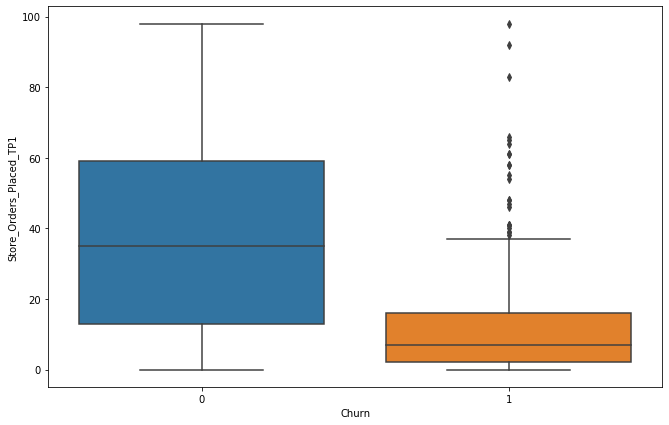

In [45]:
fig = plt.gcf()
fig.set_size_inches( 11, 7)
print ('Average of Orders placed in timeperiod 1 by customers who did not churn later on i.e Churn = 0 is '+ str(df[df['Churn']==0]['Store_Orders_Placed_TP1'].mean()))
print ('Average of Orders placed in timeperiod 1 by customers who churned later on i.e Churn = 1 is '+ str(df[df['Churn']==1]['Store_Orders_Placed_TP1'].mean()))
sns.boxplot(x='Churn', y='Store_Orders_Placed_TP1' , data=df[df['Store_Orders_Placed_TP1']<100])

### Quantity

Average of Product Quantity purchased by customers who did not Churn later on i.e Churn = 0 is  776.3994565217391
Average of Product Quantity purchased by customers who Churned later on i.e Churn = 1  is  34.20597014925373


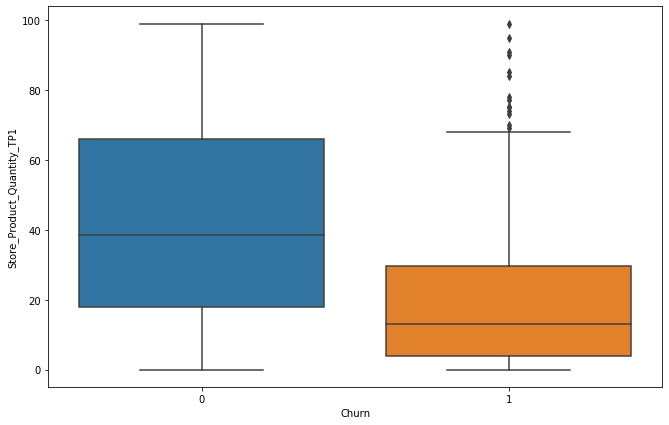

In [46]:
fig = plt.gcf()
fig.set_size_inches( 11, 7)
print ('Average of Product Quantity purchased by customers who did not Churn later on i.e Churn = 0 is  '+ str(df[df['Churn']==0]['Store_Product_Quantity_TP1'].mean()))
print ('Average of Product Quantity purchased by customers who Churned later on i.e Churn = 1  is  '+ str(df[df['Churn']==1]['Store_Product_Quantity_TP1'].mean()))
sns.boxplot(x='Churn', y='Store_Product_Quantity_TP1' , data=df[df['Store_Product_Quantity_TP1']<100])

### Revenue

Average of Revenue Generated by customers who did not Churn later on i.e Churn = 0 is 12694.671195652174
Average of Revenue Generated by customers who Churned later on i.e Churn = 1 is 699.2477611940299


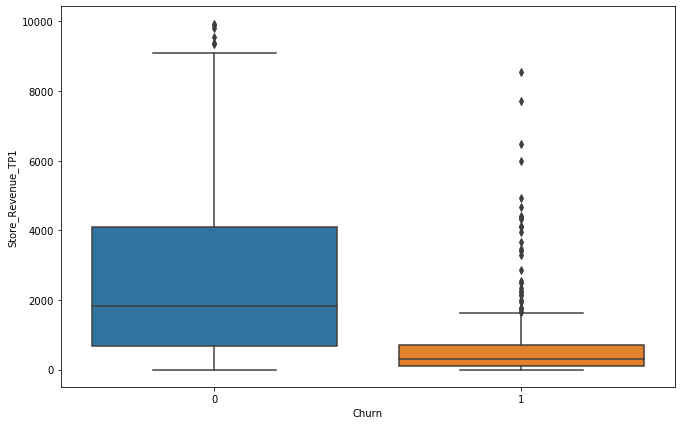

In [47]:
fig = plt.gcf()
fig.set_size_inches( 11, 7)
print ('Average of Revenue Generated by customers who did not Churn later on i.e Churn = 0 is '+ str(df[df['Churn']==0]['Store_Revenue_TP1'].mean()))
print ('Average of Revenue Generated by customers who Churned later on i.e Churn = 1 is '+ str(df[df['Churn']==1]['Store_Revenue_TP1'].mean()))
sns.boxplot(x='Churn', y='Store_Revenue_TP1' , data=df[df['Store_Revenue_TP1']<10000])

### Refund

Average of Refund to customers who did not Churn later on i.e Churn =0 is 303.6195652173913
Average of Refund to customers who Churned later on i.e Churn =1 is 33.83880597014925


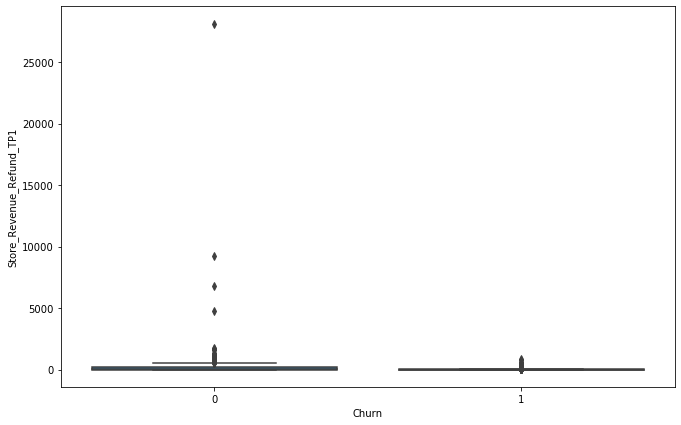

In [48]:
fig = plt.gcf()
fig.set_size_inches( 11, 7)
print ('Average of Refund to customers who did not Churn later on i.e Churn =0 is '+ str(df[df['Churn']==0]['Store_Revenue_Refund_TP1'].mean()))
print ('Average of Refund to customers who Churned later on i.e Churn =1 is '+ str(df[df['Churn']==1]['Store_Revenue_Refund_TP1'].mean()))
sns.boxplot(x='Churn', y='Store_Revenue_Refund_TP1' , data=df)

### Scatter Plots - Revenue vs Quantity
The scatter plot shows higher concentration of churn in the lower left quadrant indicating low engagement

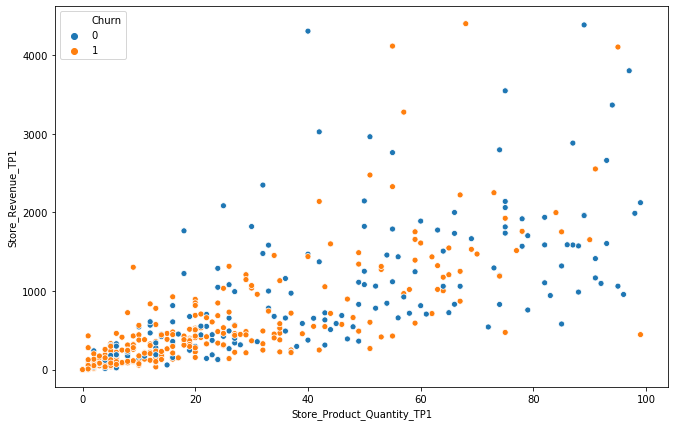

In [49]:
 fig = plt.gcf()
fig.set_size_inches( 11, 7)
ax = sns.scatterplot(x="Store_Product_Quantity_TP1", y="Store_Revenue_TP1",hue='Churn',data=df[df['Store_Product_Quantity_TP1']<100])

### Correlation

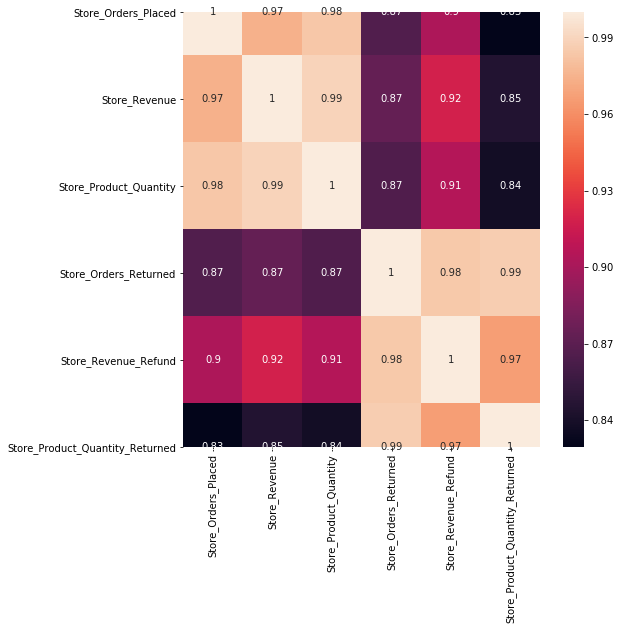

In [50]:
plt.figure(figsize=(8,8))
sns.heatmap(df.drop(['Churn','Store_Orders_Placed_TP1','Store_Orders_Placed_TP2', 'Store_Revenue_TP1','Store_Revenue_TP2',
                     'Store_Product_Quantity_TP1','Store_Product_Quantity_TP2','Store_Orders_Returned_TP1', 'Store_Orders_Returned_TP2',
                     'Store_Revenue_Refund_TP1','Store_Revenue_Refund_TP2', 'Store_Product_Quantity_Returned_TP1',
                     'Store_Product_Quantity_Returned_TP2'],axis=1).corr(), annot = True)

In [52]:
## printing out the value distribution for each variable in the dataset
for x in df.columns:
    # excluding certain columns (useless + numerical)
    if (x != '_experienceplatform.acctnumber') & (x != 'Churn') & (x!='Store_Orders_Placed_TP1') & (x != 'Store_Revenue_TP1') & (x!='Store_Product_Quantity_TP1'):
        print("{} Distribution: \n{}\n".format(str(x).upper(), df[x].value_counts(normalize=True)))

STORE_ORDERS_PLACED Distribution: 
1.0        0.048364
4.0        0.035562
5.0        0.028450
2.0        0.028450
9.0        0.025605
8.0        0.024182
13.0       0.021337
6.0        0.021337
7.0        0.019915
3.0        0.019915
12.0       0.018492
22.0       0.015647
23.0       0.014225
11.0       0.012802
26.0       0.012802
17.0       0.012802
40.0       0.011380
35.0       0.011380
19.0       0.011380
14.0       0.009957
46.0       0.009957
18.0       0.009957
10.0       0.009957
62.0       0.008535
27.0       0.008535
15.0       0.008535
28.0       0.008535
43.0       0.007112
45.0       0.007112
34.0       0.007112
             ...   
316.0      0.001422
328.0      0.001422
396.0      0.001422
148.0      0.001422
320.0      0.001422
166.0      0.001422
536.0      0.001422
2036.0     0.001422
263.0      0.001422
906.0      0.001422
271.0      0.001422
954.0      0.001422
347.0      0.001422
541.0      0.001422
289.0      0.001422
4650.0     0.001422
43083.0    0.001422
125.0

### Create dummy variables for categorical features like product category and price method

In [56]:
cat_vars=['_experienceplatform.prodcategory',
       '_experienceplatform.pricemethod']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df0[var], prefix=var)
    data1=df0.join(cat_list)
    df0=data1
data_vars=df0.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]


### Check for missing values in the data

In [61]:
missing = pd.DataFrame(df_store.isnull().sum()*100/len(df_store))
missing

,0
_experienceplatform.acctnumber,0.000000
Store_Orders_Placed,0.000000
First_Order_Date,0.000000
Last_Order_Date,0.000000
Store_Revenue,0.000000
Store_Product_Quantity,0.000000
Store_Orders_Placed_TP1,0.000000
Store_Orders_Placed_TP2,0.000000
Store_Revenue_TP1,0.000000
Store_Revenue_TP2,0.000000


In [62]:
df_store.dtypes

_experienceplatform.acctnumber                 object
Store_Orders_Placed                           float64
First_Order_Date                       datetime64[ns]
Last_Order_Date                        datetime64[ns]
Store_Revenue                                 float64
Store_Product_Quantity                        float64
Store_Orders_Placed_TP1                       float64
Store_Orders_Placed_TP2                       float64
Store_Revenue_TP1                             float64
Store_Revenue_TP2                             float64
Store_Product_Quantity_TP1                    float64
Store_Product_Quantity_TP2                    float64
Store_Orders_Returned                         float64
First_Return_Date                      datetime64[ns]
Last_Return_Date                       datetime64[ns]
Store_Revenue_Refund                          float64
Store_Product_Quantity_Returned               float64
Store_Orders_Returned_TP1                     float64
Store_Orders_Returned_TP2   

### Prepare a file with data distribution to see 25th, 50th, 75th, 90th, 95th and 95th percentile

In [63]:

distribution = pd.DataFrame([df_store.count(),df_store.isnull().sum()*100/len(df_store),
                             df_store.mean(),df_store.quantile(0), df_store.quantile(0.01), df_store.quantile(0.05),
                        df_store.quantile(0.1), df_store.quantile(0.25), df_store.quantile(0.5),
                        df_store.quantile(0.75), df_store.quantile(0.9), df_store.quantile(0.95),
                        df_store.quantile(0.99), df_store.max(), 
                        df_store.quantile(0.01)/df_store.quantile(0), df_store.max()/df_store.quantile(0.99)])
distribution = distribution.T
distribution['Vars'] = distribution.index
distribution.columns = ['Count', 'Missing_perc', 'Mean', 'Min', '1st_perc','5th_perc', '10th_perc','25th_perc', '50th_perc','75th_perc',
                       '90th_perc', '95th_perc','99th_perc','Max', '1stperc_by_Min', 'Max_by_99thperc', 'Vars']
cols = distribution.columns.tolist()
cols = cols[-1:] + cols[:-1]
distribution = distribution[cols]

distribution.to_csv("./Distribution.csv",index=False, na_rep =0)

### Drop dates as these are not being used in the model

In [65]:
df_store.drop(['First_Return_Date',
               'Last_Return_Date',
               'First_Order_Date',
               'Last_Order_Date'
               ],axis=1, inplace=True)

### Capping of outliers - this is done by looking at the distribution file and placing a cap for the values a variable takes thereby removing outliers

In [68]:
import numpy as np
df_store['Store_Orders_Placed_TP1'] = np.where(df_store['Store_Orders_Placed_TP1'] > 264, 264,
                                                      df_store['Store_Orders_Placed_TP1'])
df_store['Store_Orders_Returned_TP1'] = np.where(df_store['Store_Orders_Returned_TP1'] > 11, 11,
                                                      df_store['Store_Orders_Returned_TP1'])
df_store['Store_Product_Quantity_Returned_TP1'] = np.where(df_store['Store_Product_Quantity_Returned_TP1'] > 40, 40,
                                                      df_store['Store_Product_Quantity_Returned_TP1'])
df_store['Store_Product_Quantity_TP1'] = np.where(df_store['Store_Product_Quantity_TP1'] > 871, 871,
                                                      df_store['Store_Product_Quantity_TP1'])
df_store['Store_Revenue_Refund_TP1'] = np.where(df_store['Store_Revenue_Refund_TP1'] > 497, 497,
                                                      df_store['Store_Revenue_Refund_TP1'])
df_store['Store_Revenue_TP1'] = np.where(df_store['Store_Revenue_TP1'] > 3286, 3286,
                                                      df_store['Store_Revenue_TP1'])


In [69]:
df_store.rename(columns={'_experienceplatform.acctnumber': 'acctnumber'},inplace=True)

## This completes Data Preparation. Now we start with model building

#### Split the data into train and test - training has 80% of customers and test set has 20% of customers
This is done to validate the model, calculate accuracy, precision and recall of prediction

In [71]:
train = df_store.copy()
print("Dataset Shape:", df_store.shape)


Dataset Shape: (703, 20)


In [72]:
#Separate dependant variable
y_train = df_store['Churn']
train.drop(['Churn'], axis=1, inplace=True)
train.drop('acctnumber', axis=1, inplace=True)

## Split Data into train and test

In [73]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
train_x, test_x, train_y, test_y = train_test_split(train, y_train, test_size = 0.2, random_state = 32)

In [74]:
ntrain = train_x.shape[0]
ntest = test_x.shape[0]
df_full =  pd.concat([train_x, test_x]).reset_index(drop=True)

In [75]:
train_x = df_full[:ntrain]
test_x = df_full[ntrain:]
print(train_x.shape)
print(test_x.shape)

(562, 18)
(141, 18)


#### Below code is used to build a logistic regression model

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#classwts = {0 : 0.95, 1 : 0.05}

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression()
logreg.fit(train_x, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### Once the model is built, we validate the predicted values with test set
Note the accuracy of Logistic regression model is 77%

In [77]:
y_pred = logreg.predict(train_x)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(test_x, test_y)))

Accuracy of logistic regression classifier on test set: 0.77


### Importing some more libraries for roc curve

In [79]:
from sklearn.metrics import roc_curve, auc, mean_squared_error
#to ignore warning messages
import warnings
warnings.filterwarnings('ignore')
from subprocess import check_output

### We will build one more model using a Random Forest Regression algorithm and decide the algorithm with higher accuracy
Note - Logistic regression does not give Feature Importance

### Notice the features sorted by their importance - Number of Orders placed has highest importance

Text(0.5, 0, 'Relative Importance')

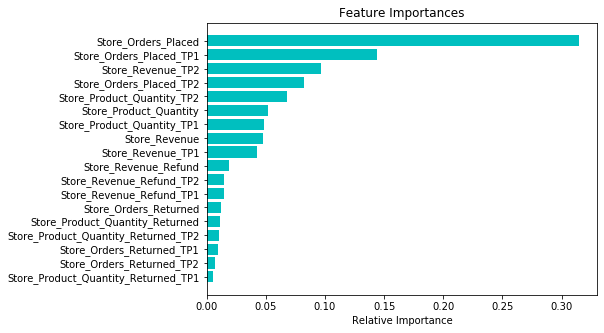

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor 

rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(train_x, train_y)
test_xp = rf.predict(test_x)
test_xp1 = np.where(test_xp > 0.12, 1,0)

# Feature importance:
features=train_x.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

# Plot for feature importance:
plt.figure(figsize=(7, 5))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='c', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')


In [82]:
importances

array([0.31435308, 0.04740769, 0.0516014 , 0.14440237, 0.08266487,
       0.04288949, 0.09661034, 0.04868556, 0.06810443, 0.01180354,
       0.01887264, 0.01118558, 0.00930236, 0.00707394, 0.01433989,
       0.01471421, 0.0058262 , 0.01016239])

### Calulating roc and plotting the roc curve (ROC - Receiver Operating Characteristics)
ROC curve gives an understanding of how well the model distinguishes between churn and non churn customers

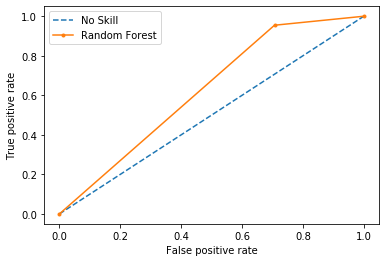

In [85]:

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score 
 


# calculate scores
ns_probs = [0 for _ in range(len(test_y))]
ns_auc = roc_auc_score(test_y, ns_probs)
rf_auc = roc_auc_score(test_y, test_xp1)
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test_y, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_y, test_xp1)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')
# show the legend
plt.legend()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
# show the plot
plt.show() 

 


### Final step - Write the output data back to platform - This is the output data which has to be created in order to score

In [94]:
# 5dbdc39ed37beb18a9704f8c - Churn_input_data
# Churn output data for scoring

from data_access_sdk_python.writer import DataSetWriter

writer = DataSetWriter()
writer.write(data_set_id="5dd319beccddf618a8a6f262", dataframe=df_store, ims_org="907075E95BF479EC0A495C73@AdobeOrg", file_format="json")

('5dd319beccddf618a8a6f262', '437923f0-0a52-11ea-86fd-412413ce33d1')